In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib_scalebar.scalebar as scalebar
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import pysal
import esda
import scipy.sparse
import libpysal as lps

from shapely.geometry import LineString, MultiLineString
from scipy.spatial import distance_matrix
from pysal.lib import weights
from pysal.explore import esda
from libpysal.weights import W
from spreg import ML_Lag, ML_Error, GM_Lag
from sklearn.decomposition import PCA
from matplotlib_scalebar.scalebar import ScaleBar
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredDirectionArrows


C:\Users\Yulin\AppData\Roaming\Python\Python311\site-packages\libpysal\cg\alpha_shapes.py:38: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
C:\Users\Yulin\AppData\Roaming\Python\Python311\site-packages\libpysal\cg\alpha_shapes.py:164: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
C:\Users\Yulin\AppData\Roaming\Python\Python311\site-packages\libpysal\cg

In [2]:
# Load spatial data with geopandas
CD = gpd.read_file('data/CommunityDistrict/nycd.shp')
SC = gpd.read_file('data/StreetCenterline/geo_export_5271be70-8d47-4770-8855-7a022145252c.shp')


In [3]:
# Check CRS of both GeoDataFrames
print("CRS of Community Districts (CD):", CD.crs)
print("CRS of Street Centerline (SC):", SC.crs)

# Align CRS
if CD.crs != SC.crs:
    SC = SC.to_crs(CD.crs)
    print("CRS of SC aligned with CD.")


CRS of Community Districts (CD): EPSG:2263
CRS of Street Centerline (SC): GEOGCS["WGS84(DD)",DATUM["WGS84",SPHEROID["WGS84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AXIS["Longitude",EAST],AXIS["Latitude",NORTH]]
CRS of SC aligned with CD.


C:\Users\Yulin\AppData\Local\Temp\ipykernel_11812\1651890242.py:17: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


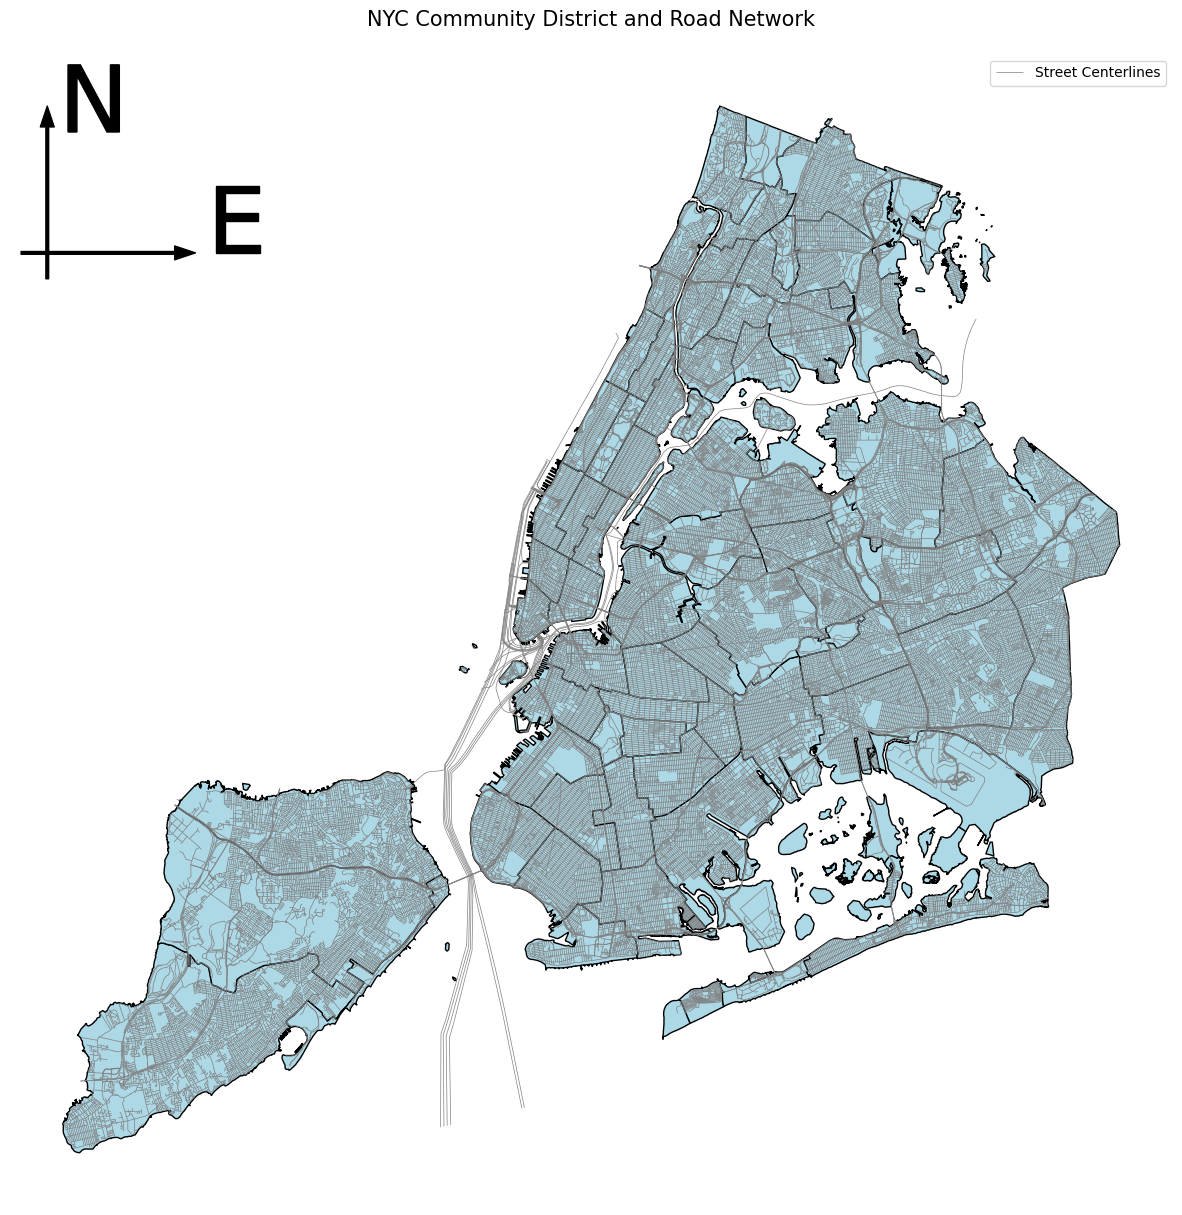

In [4]:
# Plotting
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
CD.plot(ax=ax, color='lightblue', edgecolor='black', legend=True, label='Community Districts')
SC.plot(ax=ax, color='grey', linewidth=0.5, legend=True, label='Street Centerlines')

ax.set_title("NYC Community District and Road Network", fontsize=15, pad=20)
north_arrow = AnchoredDirectionArrows(ax.transAxes, 'E', 'N', length=0.15, color='black')
ax.add_artist(north_arrow)

# Adding scale bar for EPSG:2263
# Rough conversion: 1 mile ≈ 5280 feet
scalebar_length = 5280  # 1 mile in feet
scalebar_x = 0.05  # x position in axes coordinates
scalebar_y = 0.05  # y position in axes coordinates
scalebar_text = "1 mile"

ax.legend()
ax.set_axis_off()

# Save
plt.savefig("Layout/NYC_Community_District_and_Road_Network.png", dpi=500)
plt.show()


# Spatial Weighted Matrix

## Step 1: Filter SCs

In [5]:
# Exclude streets that overlap with CD boundaries
def exclude_overlapping_streets(streets, districts):
    filtered_streets = streets[~streets.geometry.apply(lambda street: any(district.boundary.overlaps(street) for district in districts.geometry))]
    return filtered_streets

SelectedSC = exclude_overlapping_streets(SC, CD)

SelectedSC


,bike_lane,bike_trafd,borocode,date_creat,time_creat,frm_lvl_co,full_stree,l_blkfc_id,l_high_hn,l_low_hn,...,segment_ty,shape_leng,snow_pri,st_label,st_name,st_width,status,to_lvl_co,trafdir,geometry
0,NaN,NaN,1,2007-11-29,00:00:00.000,13.0,BATTERY PL,2.122626e+08,64,50,...,U,262.777812,C,BATTERY PL,BATTERY,42.0,2,13.0,TW,"LINESTRING (979278.645 196555.536, 979295.647 ..."
1,NaN,NaN,1,2007-11-29,00:00:00.000,13.0,BATTERY PL,1.222601e+09,82,66,...,U,259.415989,C,BATTERY PL,BATTERY,42.0,2,13.0,TW,"LINESTRING (979377.464 196797.796, 979503.340 ..."
2,NaN,NaN,1,2007-11-29,00:00:00.000,13.0,BATTERY PL,1.222601e+09,98,84,...,U,280.444781,C,BATTERY PL,BATTERY,42.0,2,13.0,TW,"LINESTRING (979503.340 197024.626, 979640.551 ..."
3,NaN,NaN,1,2007-11-29,00:00:00.000,13.0,BATTERY PL,2.122626e+08,NaN,NaN,...,U,32.070139,C,BATTERY PL,BATTERY,42.0,2,13.0,TW,"LINESTRING (979553.795 196059.672, 979522.805 ..."
4,NaN,NaN,1,2011-04-22,00:00:00.000,13.0,BATTERY PL,2.122626e+08,NaN,NaN,...,T,206.271850,C,BATTERY PL,BATTERY,24.0,2,13.0,TF,"LINESTRING (980288.141 195963.026, 980265.660 ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121184,NaN,NaN,2,2007-11-29,00:00:00.000,17.0,ALEXANDER HAMILTON BRG,1.322600e+09,NaN,NaN,...,R,90.966005,C,ALEXANDER HAMILTON BRG,ALEXANDER HAMILTON,48.0,2,17.0,FT,"LINESTRING (1004137.706 247257.428, 1004149.94..."
121185,NaN,NaN,2,2007-11-29,00:00:00.000,17.0,ALEXANDER HAMILTON BRG,1.322602e+09,NaN,NaN,...,R,43.822043,C,ALEXANDER HAMILTON BRG,ALEXANDER HAMILTON,48.0,2,17.0,TF,"LINESTRING (1004157.519 247311.145, 1004172.56..."
121186,NaN,NaN,5,2007-11-29,00:00:00.000,13.0,W CASTOR PL,1.722606e+09,129,0,...,U,330.903694,S,W CASTOR PL,CASTOR,36.0,2,13.0,TW,"LINESTRING (927799.796 137639.412, 927766.691 ..."
121187,NaN,NaN,3,2007-11-29,00:00:00.000,13.0,WILLIAMS AVE,0.000000e+00,NaN,NaN,...,U,34.960822,C,WILLIAMS AVE,WILLIAMS,30.0,2,13.0,FT,"LINESTRING (1011761.601 185801.535, 1011768.18..."


In [6]:
# Exclude streets that not intersecte with CD boundaries
def exclude_non_intersecting_streets(streets, districts):
    filtered_streets = streets[streets.geometry.apply(lambda street: any(district.boundary.intersects(street) for district in districts.geometry))]
    return filtered_streets

SelectedSC = exclude_non_intersecting_streets(SC, CD)

SelectedSC


,bike_lane,bike_trafd,borocode,date_creat,time_creat,frm_lvl_co,full_stree,l_blkfc_id,l_high_hn,l_low_hn,...,segment_ty,shape_leng,snow_pri,st_label,st_name,st_width,status,to_lvl_co,trafdir,geometry
11,NaN,NaN,1,2007-11-29,00:00:00.000,9.0,HUGH L CAREY TUNL,2.122618e+08,NaN,NaN,...,R,193.848515,V,HUGH L CAREY TUNL,HUGH L CAREY,40.0,2,5.0,TF,"LINESTRING (979838.464 194838.006, 979841.426 ..."
12,NaN,NaN,1,2007-11-29,00:00:00.000,9.0,HUGH L CAREY TUNL,2.122618e+08,NaN,NaN,...,R,181.489755,V,HUGH L CAREY TUNL,HUGH L CAREY,18.0,2,9.0,TF,"LINESTRING (980884.433 191405.743, 980808.865 ..."
13,NaN,NaN,1,2007-11-29,00:00:00.000,9.0,HUGH L CAREY TUNL,2.122618e+08,NaN,NaN,...,R,364.167768,V,HUGH L CAREY TUNL,HUGH L CAREY,18.0,2,9.0,TF,"LINESTRING (981864.680 189171.896, 981813.332 ..."
15,NaN,NaN,1,2007-11-29,00:00:00.000,9.0,HUGH L CAREY TUNL,2.122601e+08,NaN,NaN,...,R,213.647941,V,HUGH L CAREY TUNL,HUGH L CAREY,40.0,2,5.0,FT,"LINESTRING (979902.934 194763.334, 979900.688 ..."
16,NaN,NaN,1,2007-11-29,00:00:00.000,9.0,HUGH L CAREY TUNL,2.122601e+08,NaN,NaN,...,R,182.231104,V,HUGH L CAREY TUNL,HUGH L CAREY,18.0,2,9.0,FT,"LINESTRING (980967.070 191446.957, 980889.495 ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121141,NaN,NaN,1,2007-11-29,00:00:00.000,13.0,LENOX AVE,1.322608e+09,0,0,...,R,246.777744,C,LENOX AVE,LENOX,30.0,2,13.0,FT,"LINESTRING (997436.269 230089.907, 997449.033 ..."
121164,NaN,NaN,4,2007-11-29,00:00:00.000,13.0,WOODHAVEN BLVD,5.226014e+07,NaN,NaN,...,R,767.886702,C,WOODHAVEN BLVD,WOODHAVEN,30.0,2,13.0,TF,"LINESTRING (1026947.341 188605.470, 1026985.31..."
121166,NaN,NaN,4,2007-11-29,00:00:00.000,13.0,WOODHAVEN BLVD,5.226211e+07,102-099,101-001,...,R,768.678771,C,WOODHAVEN BLVD,WOODHAVEN,20.0,2,13.0,TF,"LINESTRING (1026978.017 188616.251, 1027014.90..."
121168,NaN,NaN,4,2007-11-29,00:00:00.000,13.0,WOODHAVEN BLVD,5.226016e+07,NaN,NaN,...,R,660.165233,C,WOODHAVEN BLVD,WOODHAVEN,30.0,2,13.0,FT,"LINESTRING (1026953.866 188495.409, 1026985.41..."


In [7]:
# Save
SelectedSC.to_file('data/SelectedStreetCenterline/SelectedSC.shp')


## Step 2: Calculate Weights

### Create a 5-Meter Buffer for Each Street in SelectedSC

In [8]:
# Create 5 meter buffer for each street
SCBuffer = SelectedSC.copy()
SCBuffer['geometry'] = SCBuffer.geometry.buffer(5)

SCBuffer


,bike_lane,bike_trafd,borocode,date_creat,time_creat,frm_lvl_co,full_stree,l_blkfc_id,l_high_hn,l_low_hn,...,segment_ty,shape_leng,snow_pri,st_label,st_name,st_width,status,to_lvl_co,trafdir,geometry
11,NaN,NaN,1,2007-11-29,00:00:00.000,9.0,HUGH L CAREY TUNL,2.122618e+08,NaN,NaN,...,R,193.848515,V,HUGH L CAREY TUNL,HUGH L CAREY,40.0,2,5.0,TF,"POLYGON ((979836.451 194868.078, 979852.806 19..."
12,NaN,NaN,1,2007-11-29,00:00:00.000,9.0,HUGH L CAREY TUNL,2.122618e+08,NaN,NaN,...,R,181.489755,V,HUGH L CAREY TUNL,HUGH L CAREY,18.0,2,9.0,TF,"POLYGON ((980804.319 191568.671, 980804.137 19..."
13,NaN,NaN,1,2007-11-29,00:00:00.000,9.0,HUGH L CAREY TUNL,2.122618e+08,NaN,NaN,...,R,364.167768,V,HUGH L CAREY TUNL,HUGH L CAREY,18.0,2,9.0,TF,"POLYGON ((981809.034 189255.705, 981808.846 18..."
15,NaN,NaN,1,2007-11-29,00:00:00.000,9.0,HUGH L CAREY TUNL,2.122601e+08,NaN,NaN,...,R,213.647941,V,HUGH L CAREY TUNL,HUGH L CAREY,40.0,2,5.0,FT,"POLYGON ((979895.689 194867.328, 979895.690 19..."
16,NaN,NaN,1,2007-11-29,00:00:00.000,9.0,HUGH L CAREY TUNL,2.122601e+08,NaN,NaN,...,R,182.231104,V,HUGH L CAREY TUNL,HUGH L CAREY,18.0,2,9.0,FT,"POLYGON ((980884.971 191609.723, 980884.784 19..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121141,NaN,NaN,1,2007-11-29,00:00:00.000,13.0,LENOX AVE,1.322608e+09,0,0,...,R,246.777744,C,LENOX AVE,LENOX,30.0,2,13.0,FT,"POLYGON ((997444.562 230117.618, 997444.777 23..."
121164,NaN,NaN,4,2007-11-29,00:00:00.000,13.0,WOODHAVEN BLVD,5.226014e+07,NaN,NaN,...,R,767.886702,C,WOODHAVEN BLVD,WOODHAVEN,30.0,2,13.0,TF,"POLYGON ((1026989.981 188508.838, 1027022.081 ..."
121166,NaN,NaN,4,2007-11-29,00:00:00.000,13.0,WOODHAVEN BLVD,5.226211e+07,102-099,101-001,...,R,768.678771,C,WOODHAVEN BLVD,WOODHAVEN,20.0,2,13.0,TF,"POLYGON ((1027019.576 188520.721, 1027051.489 ..."
121168,NaN,NaN,4,2007-11-29,00:00:00.000,13.0,WOODHAVEN BLVD,5.226016e+07,NaN,NaN,...,R,660.165233,C,WOODHAVEN BLVD,WOODHAVEN,30.0,2,13.0,FT,"POLYGON ((1026990.079 188415.662, 1027060.662 ..."


### Create a Connection Matrix Based on CDs

In [9]:
# Create a matrix based on CD
cd_list = CD['BoroCD'].unique()
cd_matrix = pd.DataFrame(index=cd_list, columns=cd_list).fillna(0)
cd_matrix


,308,414,204,228,205,313,311,484,310,410,...,407,411,405,406,201,202,306,307,409,482
308,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
414,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
204,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
228,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
205,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
306,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
307,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
409,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Check for Region Overlap and Record Connections and Count All Connections

In [10]:
for index, street in SCBuffer.iterrows():
    overlapping_cds = CD[CD.geometry.intersects(street.geometry)]['BoroCD'].unique()
    for i in range(len(overlapping_cds)):
        for j in range(i + 1, len(overlapping_cds)):
            cd_matrix.loc[overlapping_cds[i], overlapping_cds[j]] += 1
            cd_matrix.loc[overlapping_cds[j], overlapping_cds[i]] += 1

cd_matrix


,308,414,204,228,205,313,311,484,310,410,...,407,411,405,406,201,202,306,307,409,482
308,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,15,0,0,0
414,0,0,0,0,0,0,0,35,0,0,...,0,0,0,0,0,0,0,0,0,0
204,0,0,0,0,25,0,0,0,0,0,...,0,0,0,0,27,0,0,0,0,0
228,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
205,0,0,25,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,22,0,0,0,0,0
306,15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,18,0,0
307,0,0,0,0,0,0,0,0,23,0,...,0,0,0,0,0,0,18,0,0,0
409,0,0,0,0,0,0,0,0,0,78,...,0,0,0,15,0,0,0,0,0,29


### Standardize the Values in the Matrix

In [11]:
max_value = cd_matrix.max().max()
cd_matrix_normalized = cd_matrix / max_value

cd_matrix_normalized


,308,414,204,228,205,313,311,484,310,410,...,407,411,405,406,201,202,306,307,409,482
308,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.174419,0.000000,0.000000,0.000000
414,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.406977,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
204,0.000000,0.0,0.000000,0.0,0.290698,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.313953,0.0,0.000000,0.000000,0.000000,0.000000
228,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
205,0.000000,0.0,0.290698,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.255814,0.0,0.000000,0.000000,0.000000,0.000000
306,0.174419,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.209302,0.000000,0.000000
307,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.267442,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.209302,0.000000,0.000000,0.000000
409,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.906977,...,0.0,0.0,0.000000,0.174419,0.000000,0.0,0.000000,0.000000,0.000000,0.337209


## Step 3: Visualization

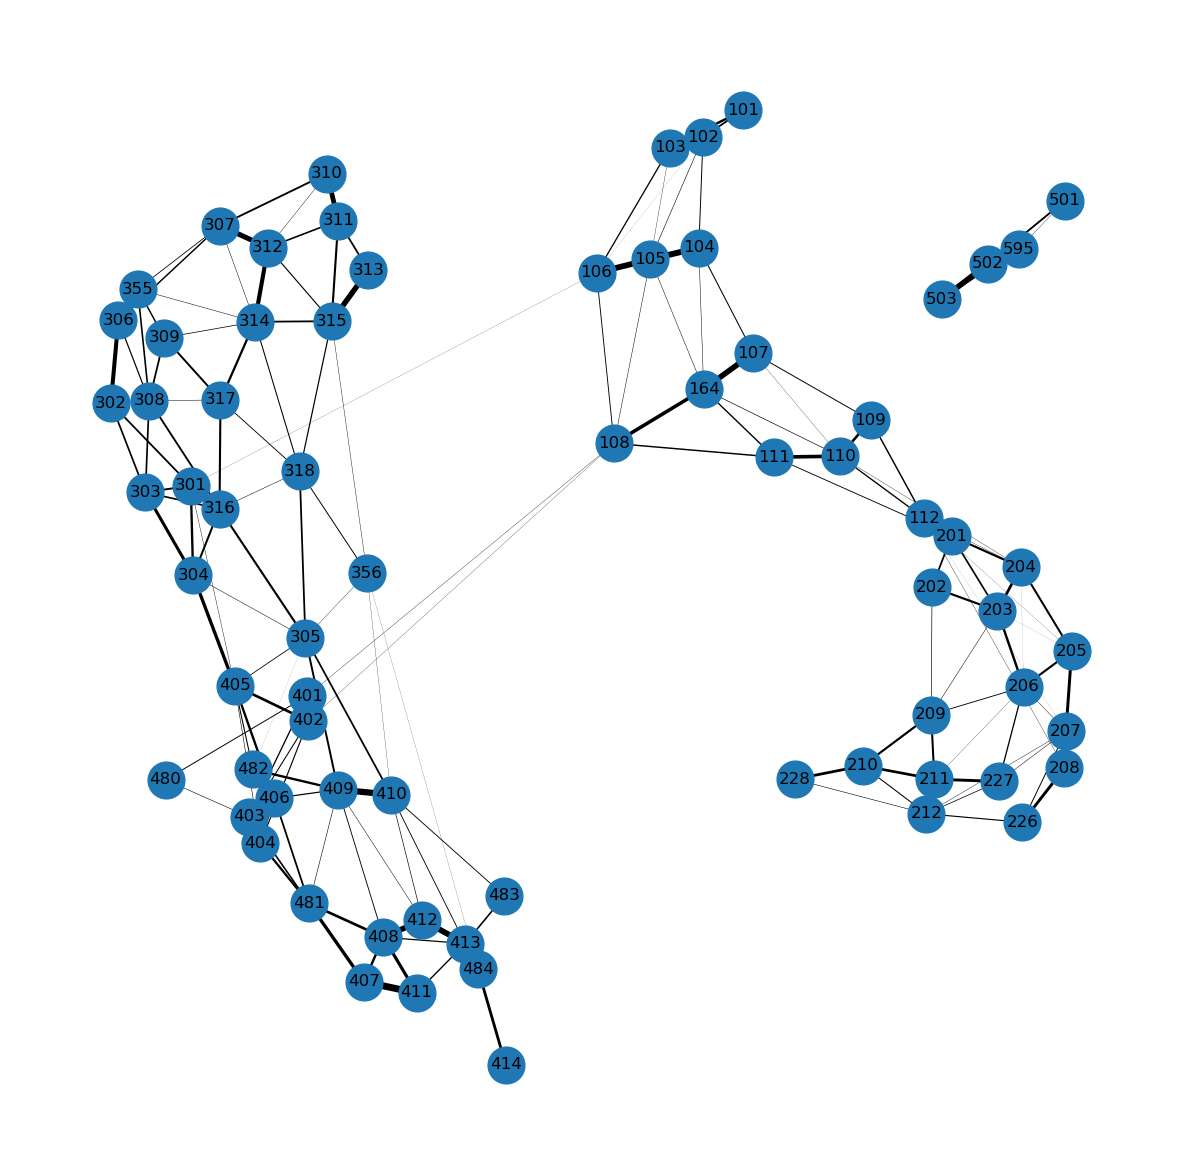

In [12]:
# Create graph 
G = nx.Graph()

# Add nodes
for cd in cd_list:
    G.add_node(cd)

# Add edges with weights
for i in cd_matrix_normalized.index:
    for j in cd_matrix_normalized.columns:
        if cd_matrix_normalized.loc[i, j] > 0:
            G.add_edge(i, j, weight=cd_matrix_normalized.loc[i, j])

# Visualization
plt.figure(figsize=(15, 15))

# Calculate layout using spring_layout
pos = nx.spring_layout(G)

# Scale positions to increase spacing
pos = {node: (x * 2, y * 2) for (node, (x, y)) in pos.items()}

nx.draw_networkx_nodes(G, pos, node_size=700)
edges = G.edges(data=True)
nx.draw_networkx_edges(G, pos, edgelist=edges, width=[d['weight']*5 for u, v, d in edges])

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=12, font_family="sans-serif")

plt.axis("off")

# Save
save_path = 'Layout'
filename = 'Weighted_Network_Graph_1.png'
if not os.path.exists(save_path):
    os.makedirs(save_path)
plt.savefig(os.path.join(save_path, filename))
plt.show()


In [13]:
# Function to calculate the product of weights along the shortest path
def path_weight_product(G, source, target):
    try:
        # Get the shortest path
        shortest_path = nx.shortest_path(G, source=source, target=target, weight='weight')
        # Calculate the product of weights along the path
        product = 1
        for i in range(len(shortest_path) - 1):
            edge_weight = G[shortest_path[i]][shortest_path[i + 1]]['weight']
            product *= edge_weight
        return product
    except nx.NetworkXNoPath:
        # Return zero if no path exists
        return 0

# Create a graph from the matrix
G = nx.Graph()

# Add nodes and edges with weights
for i in cd_matrix_normalized.index:
    for j in cd_matrix_normalized.columns:
        if cd_matrix_normalized.loc[i, j] > 0:
            G.add_edge(i, j, weight=cd_matrix_normalized.loc[i, j])

# Update the matrix with new weights for non-adjacent CDs
for i in cd_matrix_normalized.index:
    for j in cd_matrix_normalized.columns:
        if i != j and cd_matrix_normalized.loc[i, j] == 0:
            new_weight = path_weight_product(G, i, j)
            cd_matrix_normalized.loc[i, j] = new_weight

# Save
cd_matrix_normalized.to_csv('updated_cd_matrix_normalized.csv')

cd_matrix_normalized


,308,414,204,228,205,313,311,484,310,410,...,407,411,405,406,201,202,306,307,409,482
308,0.000000e+00,1.178504e-05,1.976352e-10,5.058230e-16,2.137752e-13,1.203757e-04,4.705597e-04,2.895752e-05,1.473130e-05,4.343628e-05,...,6.146102e-08,1.996800e-07,1.729407e-03,1.964173e-05,4.940880e-11,1.263946e-11,1.744186e-01,2.704164e-02,2.819012e-07,6.734307e-07
414,1.178504e-05,0.000000e+00,1.977308e-14,5.060676e-20,2.138786e-17,4.255708e-05,1.663595e-04,4.069767e-01,5.208034e-06,3.301596e-04,...,4.671659e-07,1.517770e-06,5.118754e-05,1.309449e-06,4.943270e-15,1.264557e-15,2.055530e-06,1.392777e-05,2.142734e-06,5.118754e-06
204,1.976352e-10,1.977308e-14,0.000000e+00,2.559377e-06,2.906977e-01,9.393856e-15,3.672144e-14,4.858528e-14,1.149598e-15,7.287793e-14,...,1.031201e-16,3.350256e-16,3.862870e-10,4.387251e-12,3.139535e-01,1.383526e-04,3.447126e-11,3.074353e-15,4.729773e-16,5.222918e-13
228,5.058230e-16,5.060676e-20,2.559377e-06,0.000000e+00,1.279688e-06,2.404242e-20,9.398399e-20,1.243480e-19,2.942254e-21,1.865221e-19,...,2.639231e-22,8.574568e-22,9.886540e-16,1.122863e-17,1.384195e-09,9.657175e-11,8.822494e-17,7.868427e-21,1.210527e-21,1.336742e-18
205,2.137752e-13,2.138786e-17,2.906977e-01,1.279688e-06,0.000000e+00,1.016101e-17,3.972032e-17,5.255304e-17,1.243480e-18,7.882956e-17,...,1.115414e-19,3.623857e-19,4.178334e-13,4.745539e-15,5.850004e-07,7.546505e-05,3.728638e-14,3.325422e-18,5.116034e-19,5.649452e-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,1.263946e-11,1.264557e-15,1.383526e-04,9.657175e-11,7.546505e-05,6.007698e-16,2.348464e-15,3.107198e-15,7.352078e-17,4.660798e-15,...,6.594888e-18,2.142606e-17,2.470440e-11,2.805800e-13,2.558140e-01,0.000000e+00,2.204557e-12,1.966156e-16,3.024855e-17,3.340238e-14
306,1.744186e-01,2.055530e-06,3.447126e-11,8.822494e-17,3.728638e-14,1.936113e-04,7.568443e-04,5.050730e-06,5.597620e-02,7.576095e-06,...,1.071995e-08,3.482791e-08,3.016408e-04,3.004761e-08,8.617815e-12,2.204557e-12,0.000000e+00,2.093023e-01,4.916882e-08,1.174588e-07
307,2.704164e-02,1.392777e-05,3.074353e-15,7.868427e-21,3.325422e-18,9.250319e-04,3.616034e-03,3.422252e-05,2.674419e-01,5.133379e-05,...,7.263575e-08,2.359855e-07,7.958727e-06,2.035953e-07,7.685882e-16,1.966156e-16,2.093023e-01,0.000000e+00,3.331560e-07,7.958727e-07
409,2.819012e-07,2.142734e-06,4.729773e-16,1.210527e-21,5.116034e-19,1.017977e-06,3.979363e-06,5.265004e-06,1.245776e-07,9.069767e-01,...,4.461871e-02,2.983502e-05,1.224419e-06,1.744186e-01,1.182443e-16,3.024855e-17,4.916882e-08,3.331560e-07,0.000000e+00,3.372093e-01


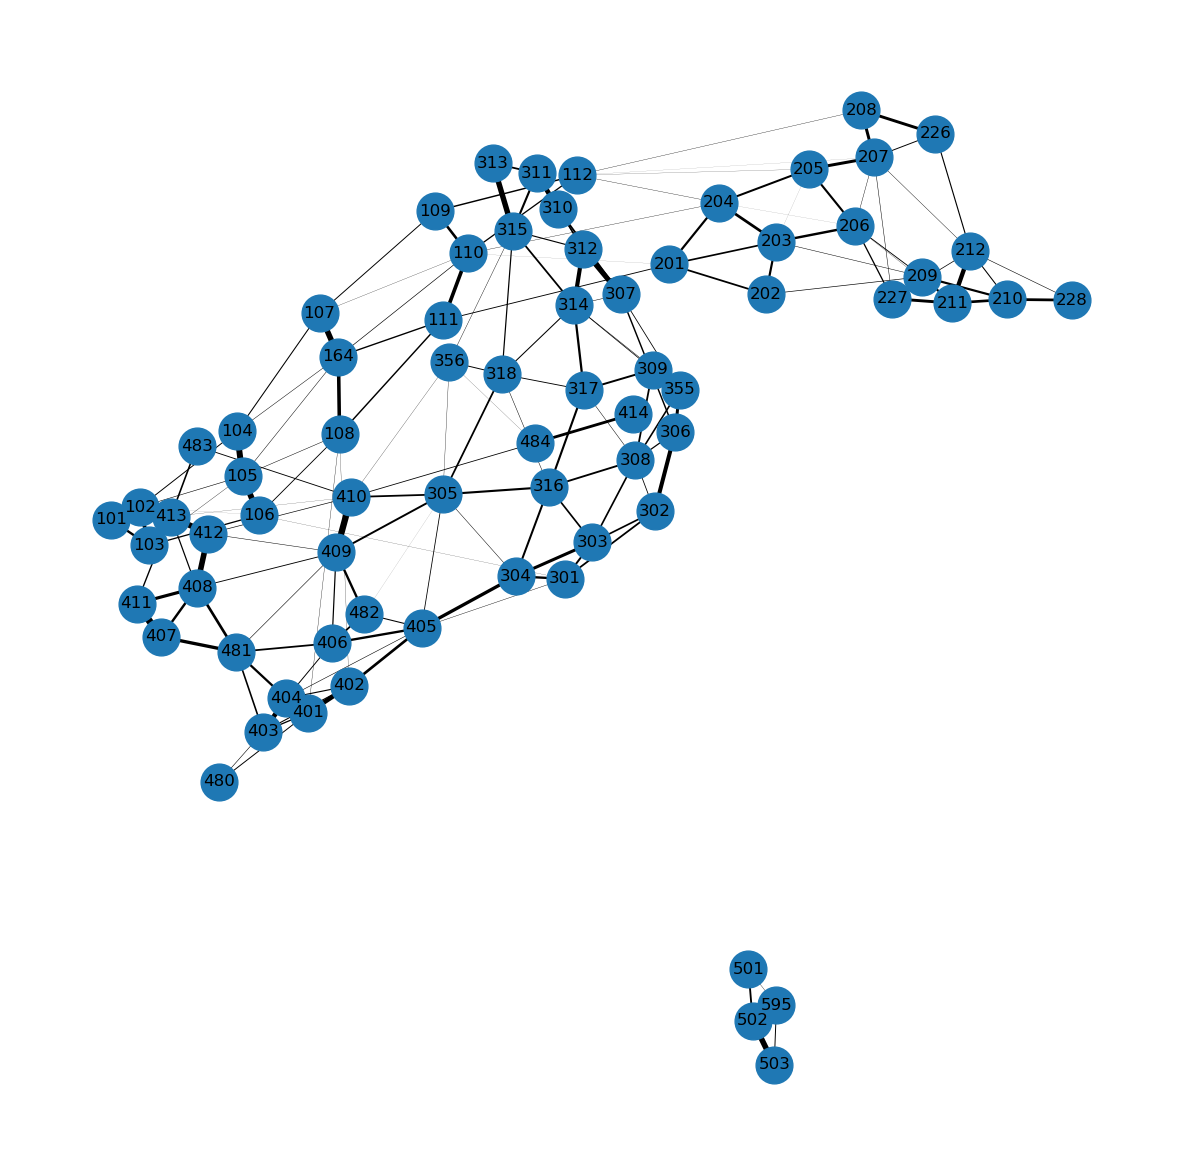

In [14]:
# Visualization
plt.figure(figsize=(15, 15))

# Calculate layout using spring_layout
pos = nx.spring_layout(G)

# Scale positions to increase spacing
pos = {node: (x * 2, y * 2) for (node, (x, y)) in pos.items()}

nx.draw_networkx_nodes(G, pos, node_size=700)
edges = G.edges(data=True)
nx.draw_networkx_edges(G, pos, edgelist=edges, width=[d['weight']*5 for u, v, d in edges])

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=12, font_family="sans-serif")

plt.axis("off")

# Save
save_path = 'Layout'
filename = 'Weighted_Network_Graph_2.png'
if not os.path.exists(save_path):
    os.makedirs(save_path)
plt.savefig(os.path.join(save_path, filename))
plt.show()


In [15]:
os.makedirs('data', exist_ok=True)
filename = 'data/SWM_SC.csv'

connections = []

# Iterate over each row
for i in cd_matrix_normalized.index:
    connected_cds = cd_matrix_normalized.loc[i][cd_matrix_normalized.loc[i] > 0]
    for j, weight in connected_cds.items():
        connections.append([i, j, weight])

connections_df = pd.DataFrame(connections, columns=['Source_CD', 'Target_CD', 'Weight'])

# Save
connections_df.to_csv(filename, index=False)

file_saved_message = f"Spatial weights matrix saved as CSV at {filename}"
file_saved_message


'Spatial weights matrix saved as CSV at data/SWM_SC.csv'

In [16]:
connections_df = pd.read_csv('data/SWM_SC.csv')

# Pivot the DataFrame to create a full matrix format
full_matrix_df = connections_df.pivot(index='Source_CD', columns='Target_CD', values='Weight')
full_matrix_df = full_matrix_df.fillna(0)
all_cds = sorted(set(connections_df['Source_CD']).union(connections_df['Target_CD']))
full_matrix_df = full_matrix_df.reindex(index=all_cds, columns=all_cds, fill_value=0)

# Save
full_matrix_filename = 'data/SWM_SC.csv'
full_matrix_df.to_csv(full_matrix_filename)

file_saved_message = f"Spatial weights matrix saved as CSV at {filename}"
file_saved_message


'Spatial weights matrix saved as CSV at data/SWM_SC.csv'

# Spatial Econometrics Model

## Step 1: Load Case Data and SWM

In [17]:
# Load the spatial weight matrices
swm_sc_df = pd.read_csv('data/SWM_SC.csv', index_col=0)
swm_distance_df = pd.read_csv('data/SMW_Distance.csv', index_col=0)

# Align the rows and columns of both matrices
aligned_swm_sc_df = swm_sc_df.reindex(index=swm_distance_df.index, columns=swm_distance_df.columns)
aligned_swm_sc_df = aligned_swm_sc_df.fillna(0)
swm_combined_df = aligned_swm_sc_df.add(swm_distance_df, fill_value=0)

# Normalize
max_value = swm_combined_df.to_numpy().max()
swm_normalized_df = swm_combined_df / max_value

swm_normalized_filename = 'data/SWM.csv'
swm_normalized_df.to_csv(swm_normalized_filename)

print(f"The new spatial weights matrix 'SWM' has been saved to {swm_normalized_filename}")
swm_normalized_df


The new spatial weights matrix 'SWM' has been saved to data/SWM.csv


,101,102,103,104,105,106,107,108,109,110,...,408,409,410,411,412,413,501,502,503,595
Source_CD,,,,,,,,,,,,,,,,,,,,,
101,0.000000e+00,3.927649e-01,4.470284e-01,2.460189e-01,1.388138e-02,1.983054e-03,3.142677e-06,2.536464e-04,4.385130e-07,9.009006e-05,...,2.051861e-12,3.282977e-12,5.058520e-10,2.325442e-12,4.705600e-11,1.176400e-11,0.000000,0.000000,0.000000,0.000000
102,3.927649e-01,0.000000e+00,5.788114e-01,9.302326e-02,5.426357e-02,7.751938e-03,1.228501e-05,9.915270e-04,2.222239e-01,3.521702e-04,...,8.020910e-12,1.283346e-11,1.977422e-09,9.090364e-12,1.839462e-10,4.598655e-11,0.000000,0.000000,0.000000,0.000000
103,3.359173e-01,4.677003e-01,0.000000e+00,1.112620e-01,1.421189e-01,2.351421e-01,7.020005e-06,2.163332e-03,1.111121e-01,2.012401e-04,...,3.036580e-14,4.858528e-14,7.486182e-12,3.441458e-14,6.963891e-13,1.740973e-13,0.000000,0.000000,0.000000,0.000000
104,1.904633e-01,9.302326e-02,1.668176e-01,0.000000e+00,7.403101e-01,1.677483e-01,1.007752e-01,2.263952e-04,1.406165e-02,4.326663e-03,...,1.119197e-12,1.790715e-12,2.759193e-10,1.268423e-12,2.566691e-11,6.416728e-12,0.000000,0.000000,0.000000,0.000000
105,1.388138e-02,5.426357e-02,1.976744e-01,7.403101e-01,0.000000e+00,7.248062e-01,1.668176e-01,4.651163e-02,2.106001e-05,4.326663e-03,...,6.528648e-13,1.044584e-12,1.609529e-10,7.399134e-13,1.497236e-11,3.743091e-12,0.000000,0.000000,0.000000,0.000000
106,1.983054e-03,7.751938e-03,2.351421e-01,1.121928e-01,6.692506e-01,0.000000e+00,1.111113e-01,8.527132e-02,1.111111e-01,4.095003e-06,...,6.897982e-10,1.103677e-09,1.700583e-07,7.817713e-10,1.581937e-08,3.954843e-09,0.000000,0.000000,0.000000,0.000000
107,3.142677e-06,1.228501e-05,7.020005e-06,1.007752e-01,1.668176e-01,1.666668e-01,0.000000e+00,1.666772e-01,9.302326e-02,2.325581e-02,...,1.478054e-16,2.364887e-16,3.643896e-14,1.675128e-16,3.389671e-15,8.474177e-16,0.000000,0.000000,0.000000,0.000000
108,2.536464e-04,9.915270e-04,2.163332e-03,2.263952e-04,4.651163e-02,8.527132e-02,6.666772e-01,0.000000e+00,1.469303e-06,3.018602e-04,...,8.823001e-11,6.654380e-05,2.175164e-08,9.999401e-11,2.023408e-09,5.058520e-10,0.000000,0.000000,0.000000,0.000000
109,4.385130e-07,1.333350e-01,1.333343e-01,1.406165e-02,2.106001e-05,1.333334e-01,9.302326e-02,1.469303e-06,0.000000e+00,3.813953e-01,...,2.062401e-17,3.299842e-17,5.084506e-15,2.337388e-17,4.729773e-16,1.182443e-16,0.000000,0.000000,0.000000,0.000000


In [18]:
# Load and convert the spatial weights matrix
def load_and_convert_swm(swm_filename):
    swm_df = pd.read_csv(swm_filename, index_col=0)
    swm_matrix = swm_df.to_numpy()
    neighbors = {i: swm_matrix[i].nonzero()[0].tolist() for i in range(len(swm_matrix))}
    weights = {i: swm_matrix[i, neighbors[i]].tolist() for i in range(len(swm_matrix))}
    return lps.weights.W(neighbors, weights)

swm = 'data/SWM.csv'
w = load_and_convert_swm(swm)
swm_distance = 'data/SMW_Distance.csv'
w_d = load_and_convert_swm(swm_distance)


C:\Users\Yulin\AppData\Roaming\Python\Python311\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
C:\Users\Yulin\AppData\Roaming\Python\Python311\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  warnings.warn(message)


## Step 2: Filter Variables

In [19]:
CD_econ = gpd.read_file('data/ModelData/gdf_CD_econ.shp')

CD_econ = CD_econ.set_index('CD').loc[swm_normalized_df.columns.astype(str)].reset_index()
CD_econ.rename(columns={'index': 'CD'}, inplace=True)
CD_econ_filtered = CD_econ[CD_econ['CD'] != '414']

economic_indicators = [col for col in CD_econ.columns if col not in ['CD', 'geometry', 'Complaint', 'Summons', 'Shooting']]
dependent_vars = ['Complaint', 'Summons', 'Shooting']
aic_values = {}

print("GeoDataFrame:")
print(CD_econ.head())


GeoDataFrame:
    CD  Complaint   Summons  Shooting   Pop16pl        LF     CvLF1  \
0  101   1.091229  3.681103  0.618809 -1.158867 -1.409311 -1.409735   
1  102  -0.510378  0.645126  0.720530 -1.919140 -1.920960 -1.920414   
2  103   0.399828  0.253776  1.025696 -1.273336 -1.389466 -1.387978   
3  104   1.306146  0.563846  2.246360 -0.010489 -0.158143 -0.157523   
4  105   0.304864 -0.465707  1.737750 -0.384514 -0.442533 -0.448800   

   CvEm16pl1  CvLFUEm1   LFArmdF  ...  Pv100t124  Pv125t149  Pv150t174  \
0  -1.452935 -0.404847  0.073144  ...   0.239885   0.283998  -0.766665   
1  -1.952900 -0.842547 -0.445344  ...  -0.654842  -0.758920  -1.022298   
2  -1.439988 -0.293975 -0.852727  ...   0.382475  -0.300878  -0.031159   
3  -0.294980  1.418978 -0.315722  ...   1.420395   0.873583   1.336383   
4  -0.597153  1.357086  2.998895  ...   1.157222   1.384996   0.887263   

   Pv175t184  Pv185t199  Pv200t299  Pv300t399  Pv400t499   Pv500pl  \
0  -0.078283  -0.348809  -0.721479  -1.00443

### Reducing the dimensionality of the independent variable

#### Correlation-Based Feature Selection

In [20]:
# Function for feature selection
def feature_selection(gdf, dependent_var):
    correlation_matrix = gdf.corr()
    correlation_with_dependent_var = correlation_matrix[dependent_var].sort_values(ascending=False)
    selected_features = correlation_with_dependent_var[np.abs(correlation_with_dependent_var) > 0.3].index.tolist()
    potential_dependent_vars = ['Complaint', 'Summons', 'Shooting']
    selected_features = [feature for feature in selected_features if feature not in potential_dependent_vars]
    return selected_features


#### Principal Component Analysis (PCA)

In [21]:
# Apply PCA
def perform_pca(gdf, selected_features):
    X_selected = gdf[selected_features].values
    pca = PCA(n_components=5)
    X_pca = pca.fit_transform(X_selected)
    return X_pca, pca


#### Reducing the dimensionality

In [22]:
dependent_vars = ['Complaint', 'Summons', 'Shooting']
# Apply feature selection for each dependent variable
selected_features_complaint = feature_selection(CD_econ_filtered, 'Complaint')
selected_features_summons = feature_selection(CD_econ_filtered, 'Summons')
selected_features_shooting = feature_selection(CD_econ_filtered, 'Shooting')
X_pca_complaint, pca_complaint = perform_pca(CD_econ_filtered, selected_features_complaint)
X_pca_summons, pca_summons = perform_pca(CD_econ_filtered, selected_features_summons)
X_pca_shooting, pca_shooting = perform_pca(CD_econ_filtered, selected_features_shooting)


C:\Users\Yulin\AppData\Local\Temp\ipykernel_11812\1328728403.py:3: FutureWarning: The default value of numeric_only in GeoDataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = gdf.corr()


In [23]:
X_pca_complaint, pca_complaint, selected_features_complaint


(array([[-1.32497339e+00,  6.52170422e+00, -1.16708202e+00,
         -5.76223529e-01, -2.73098786e-01],
        [ 6.57055153e+00,  3.52292967e+00,  9.31545581e-01,
          1.39193148e+00, -6.29769324e-02],
        [ 4.21589140e-01,  4.75449859e+00,  3.15029355e-02,
          6.42350446e-01, -1.55781703e-01],
        [-8.58503514e+00,  3.91562695e+00,  1.09457642e-01,
          1.11631467e+00,  3.65463682e-01],
        [-6.47142342e+00,  4.13398379e+00, -6.30795264e-02,
          2.33495538e+00, -2.49203058e-01],
        [ 8.77733371e-01,  5.10760173e+00, -7.62430310e-01,
          1.28362964e+00, -2.46358764e-01],
        [-6.06220437e+00,  2.51974158e+00,  2.31494672e-01,
          2.48862769e+00,  3.88597028e-01],
        [ 4.03398154e+00,  1.11587968e+00, -1.57621546e-01,
          2.98700667e-02,  1.23007454e-01],
        [-7.92851068e+00,  2.71544662e+00, -1.86900757e-01,
         -3.87491099e-01, -1.02289095e+00],
        [ 2.09884816e+00, -8.17878751e-02,  8.27487827e-01,
    

In [24]:
X_pca_summons, pca_summons, selected_features_summons


(array([[ 5.07419242e+00, -1.10589107e+00,  1.00385419e+00,
         -7.74998903e-01, -2.04510081e-01],
        [-1.71246678e+00,  1.41304131e-01,  1.42926142e-01,
         -2.42333025e-01,  4.49455269e-02],
        [ 2.53882700e+00, -1.33046752e-01,  3.71331337e-01,
          1.11326023e-02,  3.84096751e-01],
        [ 6.01117665e+00,  2.05612436e-01,  4.96614275e-01,
         -2.59159094e-01,  1.53709850e-02],
        [ 5.66751258e+00,  1.54408664e-01, -3.54571222e-01,
         -1.74807817e-02, -1.94636197e-01],
        [ 2.55295132e+00,  2.57135445e-01,  1.02341389e-01,
         -7.00619138e-01,  5.13196501e-01],
        [ 4.18529215e+00,  9.25222881e-01,  3.89531818e-01,
         -8.07406095e-01,  5.36919537e-01],
        [-1.31789148e+00, -1.23000373e-01,  4.51409652e-01,
         -2.34464345e-01,  1.19803365e-01],
        [ 5.38820160e+00, -3.58662834e-01,  1.27809262e-02,
         -1.41088333e-01, -1.11081025e+00],
        [-1.68094158e+00,  2.23957569e-01, -2.27180882e-01,
    

In [25]:
X_pca_shooting, pca_shooting, selected_features_shooting


(array([[-4.60734100e+00, -4.73116712e+00,  3.79572227e+00,
         -7.46400846e-01, -1.19890052e+00],
        [ 2.45215080e+00, -6.37051476e+00, -4.17353095e-01,
          6.30385470e-01, -3.60258496e-01],
        [-2.85473104e+00, -4.67258810e+00,  1.69127432e+00,
          1.21193815e-01, -3.36526358e-01],
        [-9.96847520e+00, -8.97878772e-01,  2.04790378e+00,
          4.89146357e-01,  1.21846353e+00],
        [-8.54681526e+00, -1.74907874e+00,  1.70225830e+00,
          1.53226548e+00,  9.82689538e-01],
        [-2.61915360e+00, -4.90869182e+00,  2.08202119e+00,
          9.48129951e-01, -6.61253150e-01],
        [-7.59874863e+00, -1.26553794e+00,  7.05490984e-01,
          1.59195030e+00,  1.24804620e+00],
        [ 2.57384027e+00, -2.45960267e+00, -1.03528344e-01,
         -6.36407297e-02, -6.74970616e-01],
        [-8.56083611e+00, -1.45170243e-01,  1.81603597e+00,
          3.94386128e-02, -4.11878985e-01],
        [ 1.01308925e+00, -1.61811942e+00, -1.46397377e+00,
    

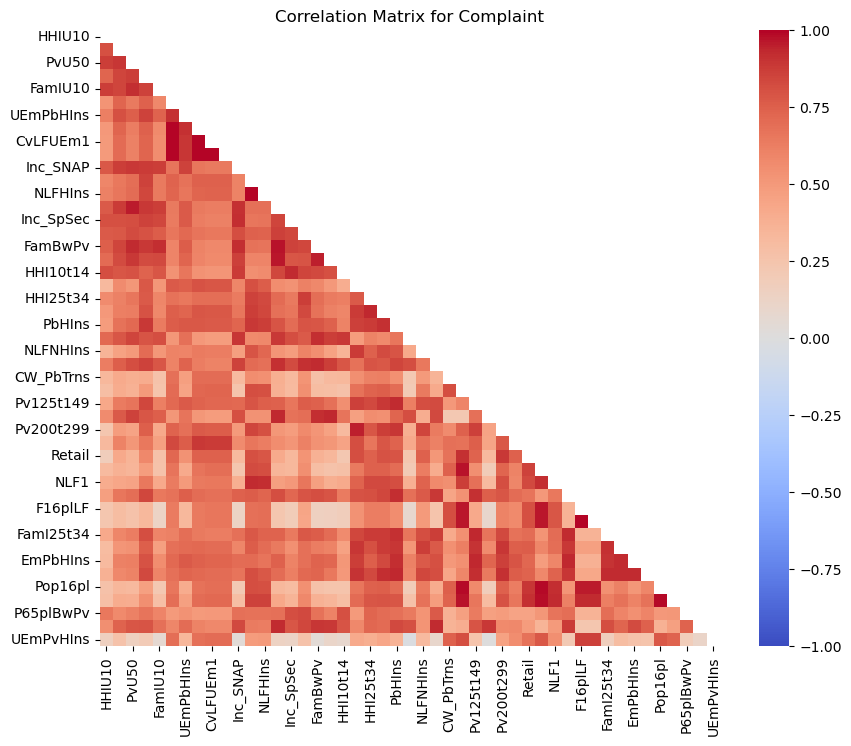

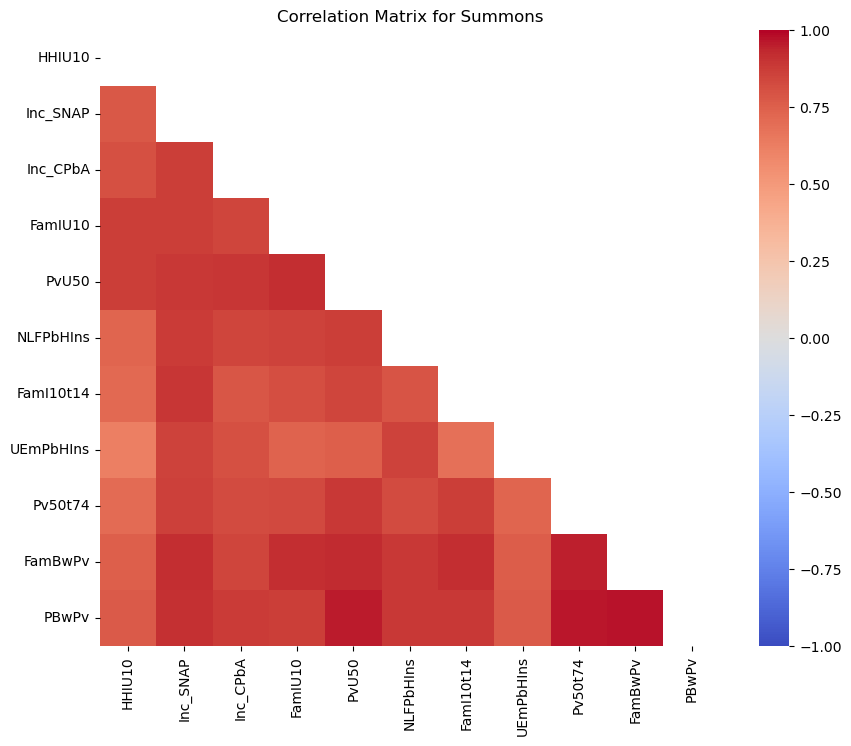

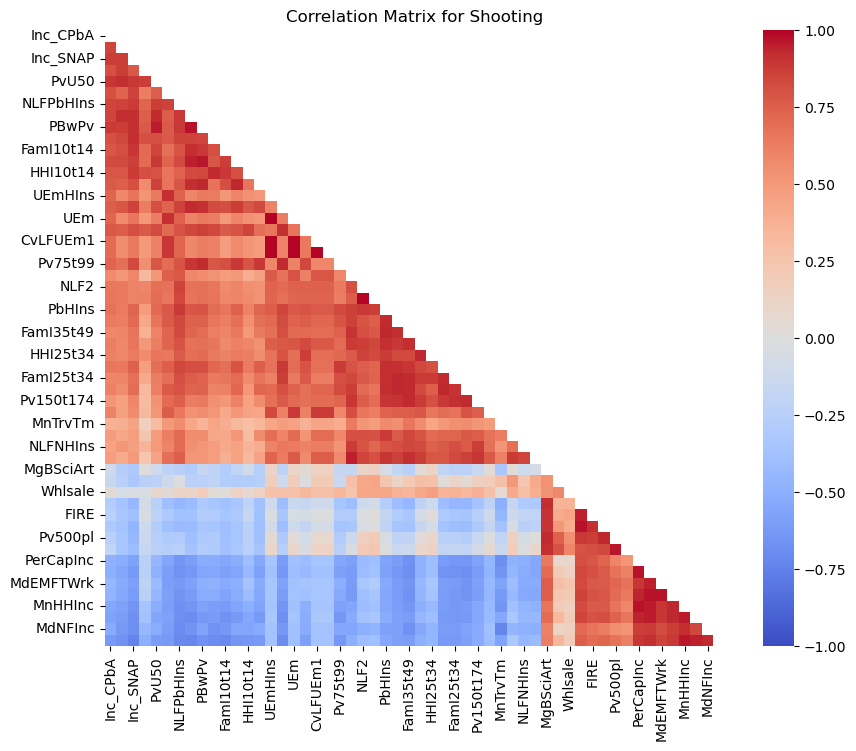

In [26]:
# Function for triangular correlation matrix visualization without numbers
def plot_triangular_correlation_matrix(gdf, selected_features, title, filename):
    correlation_matrix = gdf[selected_features].corr()
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, mask=mask, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title(title)
    plt.savefig(f'Layout/{filename}.png')
    plt.show()

# Plot and save triangular correlation matrices
plot_triangular_correlation_matrix(CD_econ_filtered, selected_features_complaint, 'Correlation Matrix for Complaint', 'Complaint_Correlation_Matrix')
plot_triangular_correlation_matrix(CD_econ_filtered, selected_features_summons, 'Correlation Matrix for Summons', 'Summons_Correlation_Matrix')
plot_triangular_correlation_matrix(CD_econ_filtered, selected_features_shooting, 'Correlation Matrix for Shooting', 'Shooting_Correlation_Matrix')


## Step 3: Spatial Autocorrelation: Moran's I

In [27]:
variables = ['Complaint', 'Summons', 'Shooting']
significant_vars_w = []
significant_vars_w_d = []

# Analyze with weight 'w'
for var in variables:
    moran_w = esda.Moran(CD_econ[var], w)
    print(f"Moran's I for {var} with 'w': {moran_w.I}, p-value: {moran_w.p_sim}")
    if moran_w.p_sim < 0.05:
        significant_vars_w.append((var, moran_w.p_sim))

# Analyze with weight 'w_d'
for var in variables:
    moran_w_d = esda.Moran(CD_econ[var], w_d)
    print(f"Moran's I for {var} with 'w_d': {moran_w_d.I}, p-value: {moran_w_d.p_sim}")
    if moran_w_d.p_sim < 0.05:
        significant_vars_w_d.append((var, moran_w_d.p_sim))

print(f"Statistically significant variables with 'w': {significant_vars_w}")
print(f"Statistically significant variables with 'w_d': {significant_vars_w_d}")


Moran's I for Complaint with 'w': 0.042935177607911774, p-value: 0.269
Moran's I for Summons with 'w': 0.16509958508243675, p-value: 0.029
Moran's I for Shooting with 'w': 0.3208254372669795, p-value: 0.003
Moran's I for Complaint with 'w_d': 0.061441359145343266, p-value: 0.216
Moran's I for Summons with 'w_d': 0.11668497624032842, p-value: 0.086
Moran's I for Shooting with 'w_d': 0.27452275828146133, p-value: 0.008
Statistically significant variables with 'w': [('Summons', 0.029), ('Shooting', 0.003)]
Statistically significant variables with 'w_d': [('Shooting', 0.008)]


## Step 4: Geographically Weighted Regression (GWR)

In [28]:
def perform_gwr(gdf, X_pca, pca, selected_features, w, dependent_var):
    y = gdf[dependent_var].values.reshape(-1, 1)
    ml_lag_model = ML_Lag(y, X_pca, w=w)
    summary = ml_lag_model.summary

    independent_features = [feat for feat in selected_features if feat != dependent_var]

    p_values = [item[1] for item in ml_lag_model.z_stat]
    coefficients = [item[0] for item in ml_lag_model.z_stat]
    significant_pca_vars = [i for i, p in enumerate(p_values[1:]) if p < 0.05]

    significant_original_vars_with_coeff = []
    num_pca_components = pca.components_.shape[0]

    for i in significant_pca_vars:
        if i < num_pca_components: 
            loadings = pca.components_[i]
            for j, loading in enumerate(loadings):
                if j < len(independent_features): 
                    original_var = independent_features[j]
                    coeff = coefficients[i+1] * loading
                    significant_original_vars_with_coeff.append((original_var, coeff))

    # Aggregate and sort coefficients
    aggregated_coeffs = {}
    for var, coeff in significant_original_vars_with_coeff:
        if var in aggregated_coeffs:
            aggregated_coeffs[var] += coeff
        else:
            aggregated_coeffs[var] = coeff

    sorted_significant_vars_with_coeff = sorted(aggregated_coeffs.items(), key=lambda x: abs(x[1]), reverse=True)

    return summary, sorted_significant_vars_with_coeff


def perform_gwr_analysis(gdf, X_pca, pca, selected_features, w, dependent_var, variables_dict):
    summary, significant_original_vars_with_coeff = perform_gwr(gdf, X_pca, pca, selected_features, w, dependent_var)
    p_value = variables_dict.get(dependent_var, None)
    significance_label = "" if dependent_var in variables_dict else " (Not statistically significant)"
    return summary, significant_original_vars_with_coeff, p_value, significance_label


In [29]:
# Map each dependent variable to its corresponding X_pca, pca, and selected_features
dependent_vars_map = {
    'complaint': (X_pca_complaint, pca_complaint, selected_features_complaint),
    'summons': (X_pca_summons, pca_summons, selected_features_summons),
    'shooting': (X_pca_shooting, pca_shooting, selected_features_shooting)
}

# Initialize the dictionaries
variables_w = {var: p_value for var, p_value in significant_vars_w}
variables_w_d = {var: p_value for var, p_value in significant_vars_w_d}
gwr_results = {}
all_vars_to_analyze = set(variables_w.keys()) | set(variables_w_d.keys())

for var in all_vars_to_analyze:
    var_lower = var.lower()
    if var_lower in dependent_vars_map:
        X_pca_var, pca_var, selected_features_var = dependent_vars_map[var_lower]
        gwr_results[(var, 'w')] = perform_gwr_analysis(CD_econ_filtered, X_pca_var, pca_var, selected_features_var, w, var, variables_w)
        gwr_results[(var, 'w_d')] = perform_gwr_analysis(CD_econ_filtered, X_pca_var, pca_var, selected_features_var, w_d, var, variables_w_d)
    else:
        print(f"Variable {var} not found in dependent_vars_map.")

for var in all_vars_to_analyze:
    for weight in ['w', 'w_d']:
        result_key = (var, weight)
        if result_key in gwr_results:
            summary, coeffs, p_value, significance_label = gwr_results[result_key]
            p_value_text = f"(p-value: {p_value})" if p_value is not None else ""
            print(f"GWR Results for {var} with weight '{weight}' {p_value_text} {significance_label}:")
            print(summary)
            print(f"Significant Original Variables with Coefficients: {coeffs}")
            print("\n" + "=" * 50 + "\n")
        else:
            print(f"No results for {var} with weight '{weight}'.")


GWR Results for Shooting with weight 'w' (p-value: 0.003) :
REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :     dep_var                Number of Observations:          59
Mean dependent var  :     -0.0053                Number of Variables   :           7
S.D. dependent var  :      1.0162                Degrees of Freedom    :          52
Pseudo R-squared    :      0.6192
Spatial Pseudo R-squared:  0.6198
Sigma-square ML     :       0.387                Log likelihood        :     -55.683
S.E of regression   :       0.622                Akaike info criterion :     125.366
                                                 Schwarz criterion     :     139.909

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error  

C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minimize.py:892: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "
